In [2]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import random

In [37]:
def task(env, name, server, processing_time, waiting_time):
    """task arrives, is served and leaves."""
    arrive = env.now
    with server.request() as req:
        yield req
        waiting_time.append(env.now-arrive)
        #print('Task %s arrived at: %7.4f: ' % (name, arrive))
        yield env.timeout(processing_time)
        #print('Task %s finished at %s' % (name, env.now))

In [38]:
class Setup(object):
    def __init__(self, env, arrival_rate, processing_capacity, server, waiting_times):
        self.env = env
        self.arrival_rate = arrival_rate
        self.processing_capacity = processing_capacity
        self.server = server
        self.waiting_times = waiting_times
        self.converged = env.event()
        self.action = env.process(self.run())
    
    def run(self):
        i=0
        while True:
            if  len(self.waiting_times)>2:
                mean = np.mean(self.waiting_times)
                var = 1/(len(self.waiting_times)*mean**-2)
                if var > 0.5:
                    self.converged
            try:
                arrival_time = random.expovariate(self.arrival_rate)
                yield env.timeout(arrival_time)

                processing_time = random.expovariate(self.processing_capacity)
                env.process(task(self.env, i, self.server, processing_time, waiting_times))
                i += 1
            except simpy.Interrupt:
                print('Variance converged')
                
def stop_sim(env, setup, desired_var):
    while True:
        if  len(setup.waiting_times)>2:
            mean = np.mean(setup.waiting_times)
            var = 1/(len(setup.waiting_times)*mean**-2)
            if var > desired_var:
                setup.action.interrupt

In [15]:
env = simpy.Environment()
server = simpy.Resource(env, capacity=1)
arrival_rate = 0.999999
capacity = 1
server_util = arrival_rate/capacity
number_of_samples = 10000
sim_time = number_of_samples/arrival_rate
waitingtimes = []
env.process(setup(env, arrival_rate, capacity))
env.run(until=sim_time)

Task 0 arrived at:  0.8124: 
Task 0 finished at 3.4524725254171282
Task 1 arrived at:  3.4401: 
Task 1 finished at 3.6636258992966706
Task 2 arrived at:  6.9836: 
Task 2 finished at 7.557237878758085
Task 3 arrived at:  8.0054: 
Task 3 finished at 8.558286597012593
Task 4 arrived at: 11.3670: 
Task 4 finished at 11.865813423652591
Task 5 arrived at: 12.5057: 
Task 5 finished at 12.719921333848067
Task 6 arrived at: 13.3316: 
Task 6 finished at 15.488482143341296
Task 7 arrived at: 15.4507: 
Task 7 finished at 16.49386047902338
Task 8 arrived at: 15.7663: 
Task 8 finished at 17.05357074041616
Task 9 arrived at: 16.1003: 
Task 9 finished at 17.55505691996328
Task 10 arrived at: 17.3381: 
Task 10 finished at 17.987510310564115
Task 11 arrived at: 18.4538: 
Task 11 finished at 19.293552719683408
Task 12 arrived at: 21.1718: 
Task 12 finished at 21.637500449857182
Task 13 arrived at: 22.0338: 
Task 13 finished at 22.889082073791126
Task 14 arrived at: 22.4491: 
Task 14 finished at 23.089991

Task 1314 finished at 1343.384209740657
Task 1315 arrived at: 1309.9320: 
Task 1315 finished at 1346.3378078009748
Task 1316 arrived at: 1310.2192: 
Task 1316 finished at 1347.1963563365132
Task 1317 arrived at: 1311.0165: 
Task 1317 finished at 1347.2278629224866
Task 1318 arrived at: 1311.0245: 
Task 1318 finished at 1347.300115825802
Task 1319 arrived at: 1311.0606: 
Task 1319 finished at 1347.4017039535813
Task 1320 arrived at: 1311.4532: 
Task 1320 finished at 1349.0074335156094
Task 1321 arrived at: 1312.1380: 
Task 1321 finished at 1351.0536013553067
Task 1322 arrived at: 1312.4749: 
Task 1322 finished at 1351.4909736835784
Task 1323 arrived at: 1312.6726: 
Task 1323 finished at 1351.8727951687208
Task 1324 arrived at: 1312.7387: 
Task 1324 finished at 1353.2684090304876
Task 1325 arrived at: 1313.6153: 
Task 1325 finished at 1353.278106100294
Task 1326 arrived at: 1313.8800: 
Task 1326 finished at 1353.9178793139993
Task 1327 arrived at: 1316.7228: 
Task 1327 finished at 1354.3

Task 2564 arrived at: 2541.2020: 
Task 2564 finished at 2594.091562038124
Task 2565 arrived at: 2541.5328: 
Task 2565 finished at 2595.1233488572248
Task 2566 arrived at: 2541.9347: 
Task 2566 finished at 2596.8500976596106
Task 2567 arrived at: 2542.0283: 
Task 2567 finished at 2597.282382528598
Task 2568 arrived at: 2542.0626: 
Task 2568 finished at 2597.311656178113
Task 2569 arrived at: 2543.3093: 
Task 2569 finished at 2597.6635588037147
Task 2570 arrived at: 2544.0532: 
Task 2570 finished at 2598.569053543508
Task 2571 arrived at: 2544.3515: 
Task 2571 finished at 2599.2331783374316
Task 2572 arrived at: 2546.6223: 
Task 2572 finished at 2599.4429065687987
Task 2573 arrived at: 2548.1900: 
Task 2573 finished at 2600.5078708907527
Task 2574 arrived at: 2549.5330: 
Task 2574 finished at 2601.2046252849264
Task 2575 arrived at: 2549.5485: 
Task 2575 finished at 2601.825302240189
Task 2576 arrived at: 2550.7020: 
Task 2576 finished at 2603.5904180785
Task 2577 arrived at: 2552.5709: 

Task 3814 arrived at: 3767.7512: 
Task 3814 finished at 3874.60294594562
Task 3815 arrived at: 3768.6058: 
Task 3815 finished at 3876.137882773102
Task 3816 arrived at: 3769.7718: 
Task 3816 finished at 3876.180055295538
Task 3817 arrived at: 3770.3140: 
Task 3817 finished at 3876.7511458607687
Task 3818 arrived at: 3771.3735: 
Task 3818 finished at 3878.825089389064
Task 3819 arrived at: 3772.0471: 
Task 3819 finished at 3878.8830405401645
Task 3820 arrived at: 3773.8136: 
Task 3820 finished at 3879.2447876816864
Task 3821 arrived at: 3774.6661: 
Task 3821 finished at 3880.09387402428
Task 3822 arrived at: 3775.2748: 
Task 3822 finished at 3881.305132033406
Task 3823 arrived at: 3776.3352: 
Task 3823 finished at 3882.9954823142916
Task 3824 arrived at: 3779.3967: 
Task 3824 finished at 3883.238189119439
Task 3825 arrived at: 3779.8238: 
Task 3825 finished at 3883.379227335093
Task 3826 arrived at: 3780.2003: 
Task 3826 finished at 3884.2492825504473
Task 3827 arrived at: 3780.4447: 
T

Task 5063 finished at 5173.906300667016
Task 5064 arrived at: 5098.4749: 
Task 5064 finished at 5174.089112108743
Task 5065 arrived at: 5100.4101: 
Task 5065 finished at 5174.358689882553
Task 5066 arrived at: 5100.9071: 
Task 5066 finished at 5175.746216995098
Task 5067 arrived at: 5101.3366: 
Task 5067 finished at 5176.926593726878
Task 5068 arrived at: 5101.4851: 
Task 5068 finished at 5178.074913623359
Task 5069 arrived at: 5101.5139: 
Task 5069 finished at 5182.775214072227
Task 5070 arrived at: 5101.8539: 
Task 5070 finished at 5183.4821116103085
Task 5071 arrived at: 5103.5827: 
Task 5071 finished at 5183.566624870462
Task 5072 arrived at: 5104.2565: 
Task 5072 finished at 5185.512045706785
Task 5073 arrived at: 5105.0183: 
Task 5073 finished at 5186.160165608376
Task 5074 arrived at: 5106.1653: 
Task 5074 finished at 5186.875478008825
Task 5075 arrived at: 5106.4039: 
Task 5075 finished at 5188.525121974231
Task 5076 arrived at: 5109.6450: 
Task 5076 finished at 5188.8979226665

Task 6313 finished at 6458.171638539241
Task 6314 arrived at: 6374.4319: 
Task 6314 finished at 6458.578418405765
Task 6315 arrived at: 6374.6486: 
Task 6315 finished at 6459.184576454822
Task 6316 arrived at: 6374.8289: 
Task 6316 finished at 6459.252153717742
Task 6317 arrived at: 6375.2953: 
Task 6317 finished at 6459.6924609410335
Task 6318 arrived at: 6375.4213: 
Task 6318 finished at 6461.550122116282
Task 6319 arrived at: 6376.0390: 
Task 6319 finished at 6461.760258175467
Task 6320 arrived at: 6376.4307: 
Task 6320 finished at 6462.328452041515
Task 6321 arrived at: 6377.2185: 
Task 6321 finished at 6462.366084190106
Task 6322 arrived at: 6377.6899: 
Task 6322 finished at 6463.7965594338175
Task 6323 arrived at: 6378.3563: 
Task 6323 finished at 6465.140666769462
Task 6324 arrived at: 6380.4168: 
Task 6324 finished at 6466.079793681089
Task 6325 arrived at: 6381.9692: 
Task 6325 finished at 6467.226320985151
Task 6326 arrived at: 6381.9855: 
Task 6326 finished at 6469.895615595

Task 7563 arrived at: 7665.9678: 
Task 7563 finished at 7706.811921870158
Task 7564 arrived at: 7666.2119: 
Task 7564 finished at 7707.423042647703
Task 7565 arrived at: 7668.1704: 
Task 7565 finished at 7707.777116538988
Task 7566 arrived at: 7668.6993: 
Task 7566 finished at 7708.264728075649
Task 7567 arrived at: 7670.6330: 
Task 7567 finished at 7709.285603419196
Task 7568 arrived at: 7671.8689: 
Task 7568 finished at 7710.26242682748
Task 7569 arrived at: 7672.0436: 
Task 7569 finished at 7710.638546300977
Task 7570 arrived at: 7673.5569: 
Task 7570 finished at 7710.65486872446
Task 7571 arrived at: 7673.6298: 
Task 7571 finished at 7711.389233857553
Task 7572 arrived at: 7673.7348: 
Task 7572 finished at 7713.968054813422
Task 7573 arrived at: 7673.8339: 
Task 7573 finished at 7715.31568318464
Task 7574 arrived at: 7673.9672: 
Task 7574 finished at 7716.201523528269
Task 7575 arrived at: 7674.8172: 
Task 7575 finished at 7720.580122556097
Task 7576 arrived at: 7674.8849: 
Task 75

Task 8813 arrived at: 8915.6963: 
Task 8813 finished at 8995.57256918791
Task 8814 arrived at: 8916.1697: 
Task 8814 finished at 8995.96789768204
Task 8815 arrived at: 8918.4658: 
Task 8815 finished at 8997.59911776658
Task 8816 arrived at: 8919.6556: 
Task 8816 finished at 8998.439230699676
Task 8817 arrived at: 8921.2467: 
Task 8817 finished at 8998.536777340008
Task 8818 arrived at: 8921.4477: 
Task 8818 finished at 8999.043461858528
Task 8819 arrived at: 8921.7109: 
Task 8819 finished at 8999.587877735727
Task 8820 arrived at: 8922.4262: 
Task 8820 finished at 8999.597527755113
Task 8821 arrived at: 8922.6764: 
Task 8821 finished at 9002.30266026427
Task 8822 arrived at: 8923.7081: 
Task 8822 finished at 9003.529235143154
Task 8823 arrived at: 8924.2299: 
Task 8823 finished at 9003.700432039308
Task 8824 arrived at: 8925.5501: 
Task 8824 finished at 9004.559327122086
Task 8825 arrived at: 8925.5843: 
Task 8825 finished at 9006.178861879926
Task 8826 arrived at: 8927.4205: 
Task 882

66.84653339003606 0.4559652067617556
999998.9999712444


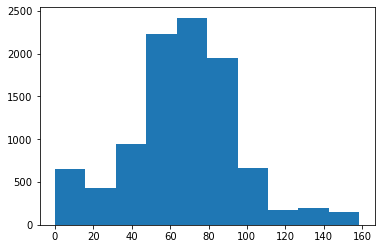

In [16]:
plt.hist(waitingtimes)
mean = np.mean(waitingtimes)
var = 1/(len(waitingtimes)*mean**-2)
print(mean, var)
print((server_util/capacity)/(1-server_util))

In [39]:
waiting_times = []
n_steps = 10
n_servers = 1
arrival_rate = 1
init_util = 0.2
server_util = np.linspace(init_util, 0.9, n_steps)
proccesing_capacity = arrival_rate*server_util
desired_var = 0.1
env = simpy.Environment()
servers = simpy.Resource(env, capacity=n_servers)

setup = Setup(env, arrival_rate, processing_capacity[0], servers, waiting_times)
env.run()

KeyboardInterrupt: 

In [34]:
setup.waiting_times

[0.0,
 6.112059950960259,
 6.80351080371643,
 14.915549710224516,
 14.955051256233235,
 15.504184106478926,
 33.25154971988984,
 40.04256547894484,
 50.12305160849743,
 53.35889502199545,
 69.5033566786517,
 69.62519244763784,
 68.92659251950518,
 76.13201426905697,
 81.98357937405952,
 89.93172473011268,
 98.92630465650609,
 99.88342263653746,
 100.2724820823716,
 101.58175046236913,
 110.24063754071891,
 111.48166625124091,
 112.09496272826917,
 122.12778050822051,
 136.78626867900425,
 142.74434344250628,
 140.82141441319087,
 150.07457239009756,
 150.08887954796427,
 159.77603298888656,
 166.46257814008504,
 168.2625851066631,
 168.14746155646043,
 171.2916862352575,
 172.9286334390901,
 175.35001994717828,
 183.50919950344655,
 189.9354318848071,
 216.94905718032564,
 217.9007812857177,
 224.17957553299416,
 230.55767957477264,
 230.00097790013166,
 230.05357568385813,
 232.2567849611755,
 231.99040826446512,
 232.24084265820113,
 233.6215487650904,
 245.77393236258388,
 264.68124